# Scalable GP Classification in 1D (w/ KISS-GP)

This example shows how to use a `GridInducingVariationalGP` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# The train data points are spaced every 1/25 between 0 and 1 inclusive
train_x = Variable(torch.linspace(0, 1, 26))
# Use the sign function (-1 if value <0, 1 if value>0) to assign
# periodic labels to the data
train_y = Variable(torch.sign(torch.cos(train_x.data * (2 * math.pi))))

In [3]:
from torch import nn, optim
from math import exp
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.random_variables import GaussianRandomVariable

In [36]:
# Create a model to classify, we use a GridInducingVariationalGP which exploits
# grid structure (the x data points are linspace)
# to get fast predictive distributions
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=32, grid_bounds=[(0, 1)])
        # Near-zero constant mean
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-1e-5, 1e-5))
        # RBF kernel as universal approximator
        self.covar_module = RBFKernel(
            log_lengthscale_prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True)
        )
        self.register_parameter(
            name="log_outputscale",
            parameter=torch.nn.Parameter(torch.Tensor([0])),
            prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True),
        )
        
    def forward(self,x):
        # Calc predictive mean (zero)
        mean_x = self.mean_module(x)
        # Calc predictive covariance
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Make predictive distribution from predictive mean and covariance
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize model
model = GPClassificationModel()
# Use Bernoulli Likelihood (warps via normal CDF to (0,1))
likelihood = BernoulliLikelihood()

In [37]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=len(train_y))

def train():
    num_iter = 200
    for i in range(num_iter):
        # Zero gradients out for new iteration
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calculate loss
        loss = -mll(output, train_y)
        # Calc gradients
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_outputscale: %.3f' % (
            i + 1, num_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
            model.log_outputscale.data.item(),
        ))
        
        print('Iter %d/%d - log_lengthscale_grad: %.3f   log_outputscale_grad: %.3f' % (
            i + 1, num_iter,
            model.covar_module.base_kernel_module.log_lengthscale.grad.item(),
            model.log_outputscale.grad.item(),
        ))
        optimizer.step()
        
# Get clock time
%time train()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter 1/200 - Loss: 611.932   log_lengthscale: 0.000   log_outputscale: 0.000
Iter 1/200 - log_lengthscale_grad: 39.535   log_outputscale_grad: -608030.938
Iter 2/200 - Loss: 439.384   log_lengthscale: -0.100   log_outputscale: 0.100
Iter 2/200 - log_lengthscale_grad: 38.641   log_outputscale_grad: -481624.312
Iter 3/200 - Loss: 317.409   log_lengthscale: -0.200   log_outputscale: 0.199
Iter 3/200 - log_lengthscale_grad: 40.319   log_outputscale_grad: -382741.406
Iter 4/200 - Loss: 236.955   log_lengthscale: -0.300   log_outputscale: 0.295
Iter 4/200 - log_lengthscale_grad: 48.675   log_outputscale_grad: -312305.688
Iter 5/200 - Loss: 172.992   log_lengthscale: -0.400   log_outputscale: 0.390
Iter 5/200 - log_lengthscale_grad: 52.310   log_outputscale_grad: -247659.672
Iter 6/200 - Loss: 118.262   log_lengthscale: -0.501   log_outputscale: 0.481
Iter 6/200 - log_lengthscale_grad: 48.333   log_outputscale_grad: -183569.016
Iter 7/200 - Loss: 76.162   log_lengthscale: -0.602   log_outputs

Iter 55/200 - Loss: 2.485   log_lengthscale: -2.750   log_outputscale: 1.799
Iter 55/200 - log_lengthscale_grad: -1.758   log_outputscale_grad: 372.178
Iter 56/200 - Loss: 2.334   log_lengthscale: -2.746   log_outputscale: 1.801
Iter 56/200 - log_lengthscale_grad: -1.777   log_outputscale_grad: 490.321
Iter 57/200 - Loss: 2.578   log_lengthscale: -2.741   log_outputscale: 1.803
Iter 57/200 - log_lengthscale_grad: -2.277   log_outputscale_grad: 389.020
Iter 58/200 - Loss: 2.578   log_lengthscale: -2.736   log_outputscale: 1.804
Iter 58/200 - log_lengthscale_grad: -1.549   log_outputscale_grad: 385.131
Iter 59/200 - Loss: 2.332   log_lengthscale: -2.730   log_outputscale: 1.805
Iter 59/200 - log_lengthscale_grad: -2.005   log_outputscale_grad: 473.167
Iter 60/200 - Loss: 2.517   log_lengthscale: -2.723   log_outputscale: 1.806
Iter 60/200 - log_lengthscale_grad: -1.233   log_outputscale_grad: 402.149
Iter 61/200 - Loss: 2.062   log_lengthscale: -2.717   log_outputscale: 1.807
Iter 61/200

Iter 110/200 - Loss: 1.679   log_lengthscale: -2.583   log_outputscale: 1.803
Iter 110/200 - log_lengthscale_grad: 0.415   log_outputscale_grad: 319.616
Iter 111/200 - Loss: 1.708   log_lengthscale: -2.585   log_outputscale: 1.803
Iter 111/200 - log_lengthscale_grad: -0.042   log_outputscale_grad: 197.004
Iter 112/200 - Loss: 1.243   log_lengthscale: -2.587   log_outputscale: 1.803
Iter 112/200 - log_lengthscale_grad: -0.214   log_outputscale_grad: 378.070
Iter 113/200 - Loss: 1.512   log_lengthscale: -2.588   log_outputscale: 1.802
Iter 113/200 - log_lengthscale_grad: -0.555   log_outputscale_grad: 345.824
Iter 114/200 - Loss: 1.359   log_lengthscale: -2.589   log_outputscale: 1.802
Iter 114/200 - log_lengthscale_grad: -0.128   log_outputscale_grad: 505.112
Iter 115/200 - Loss: 1.439   log_lengthscale: -2.590   log_outputscale: 1.802
Iter 115/200 - log_lengthscale_grad: 0.513   log_outputscale_grad: 438.800
Iter 116/200 - Loss: 1.618   log_lengthscale: -2.591   log_outputscale: 1.801


Iter 165/200 - Loss: 1.457   log_lengthscale: -2.625   log_outputscale: 1.782
Iter 165/200 - log_lengthscale_grad: -1.184   log_outputscale_grad: 221.114
Iter 166/200 - Loss: 1.305   log_lengthscale: -2.627   log_outputscale: 1.782
Iter 166/200 - log_lengthscale_grad: -0.339   log_outputscale_grad: 491.702
Iter 167/200 - Loss: 1.029   log_lengthscale: -2.628   log_outputscale: 1.781
Iter 167/200 - log_lengthscale_grad: -0.439   log_outputscale_grad: 408.740
Iter 168/200 - Loss: 1.114   log_lengthscale: -2.629   log_outputscale: 1.781
Iter 168/200 - log_lengthscale_grad: -0.560   log_outputscale_grad: 487.961
Iter 169/200 - Loss: 1.222   log_lengthscale: -2.629   log_outputscale: 1.781
Iter 169/200 - log_lengthscale_grad: -0.226   log_outputscale_grad: 253.755
Iter 170/200 - Loss: 1.007   log_lengthscale: -2.629   log_outputscale: 1.780
Iter 170/200 - log_lengthscale_grad: -0.572   log_outputscale_grad: 225.861
Iter 171/200 - Loss: 1.291   log_lengthscale: -2.628   log_outputscale: 1.78

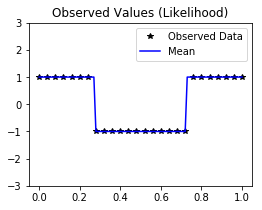

In [38]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are every 0.01 from 0 to 1 inclusive 
test_x = Variable(torch.linspace(0, 1, 101))
# Make predictions from model output Gaussian warped through Bernoulli likelihood
predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Black stars for trainng data
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Based of prediction probability label -1 or 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    # Plot test predictions as blue line
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
    
# Call plot
ax_plot(observed_ax, predictions, 'Observed Values (Likelihood)')